# HYDRAD Configuration Testing

In [1]:
import os
import subprocess
import glob
import copy
import numpy as np
from scipy.interpolate import interp1d
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import yaml

from hydrad_tools import configure, parse

%matplotlib inline

## Configuration

In [4]:
config_dict = {
    'general': {
        'total_time': 5e3 * u.s,
        'output_interval': 10 * u.s,
        'loop_length': 80 * u.Mm,
        'loop_inclination': 0 * u.deg,
        'footpoint_height': 5e8 * u.cm,
        #'tabulated_gravity_file': None,#'/path/to/gravity.file',
        #'tabulated_cross_section_file': None,#'/path/to/cross_section.file',
        #'write_file_physical': True,
        #'write_file_ion_populations': False,
        #'write_file_hydrogen_level_populations': False,
        #'write_file_timescales': False,
        #'write_file_equation_terms': False,
        #'logging_frequency': 1000,
        'heat_flux_limiting_coefficient': 1.0,
        'heat_flux_timestep_limit': 1e-10,
        #'use_kinetic_model': False,
        'minimum_collisional_coupling_timescale': 0.01 * u.s,
        #'force_single_fluid': False,
    },
    'initial_conditions': {
        'footpoint_temperature': 2e4 * u.K,
        'footpoint_density': 1e11 * u.cm**(-3),
        'heating_location': 40 * u.Mm,
        'heating_scale_height': 1e300 * u.cm,
        #'isothermal': False,
        'heating_range_lower_bound': 1e-8 * u.erg/u.s/(u.cm**3),
        'heating_range_upper_bound': 1e2 * u.erg/u.s/(u.cm**3),
        #'heating_range_step_size': 0.001,
        #'heating_range_fine_tuning': 10000.0,
    },
    'radiation': {
        'use_power_law_radiative_losses': True,
        #'decouple_ionization_state_solver': False,
        #'density_dependent_rates': False,
        #'optically_thick_radiation': False,
        #'nlte_chromosphere': False,
        'ranges_dataset': 'ranges',
        'emissivity_dataset': 'chianti_v7',
        'abundance_dataset': 'asplund',
        'rates_dataset': 'chianti_v7',
        'elements_equilibrium': ['He', 'carbon', 'nitrogen', 1],
        #'elements_nonequilibrium': None,
    },
    'heating': {
        'heat_electrons': True,
        #'beam_heating': False,
        #'alfven_wave_heating': False,
        'background_heating': True,
        'events': [
            {'time_start': 0. * u.s, 'rise_duration': 100 * u.s, 'decay_duration': 100 * u.s, 'total_duration': 200 * u.s,
             'location': 4e9 * u.cm, 'scale_height': 1e300 * u.cm, 'rate': 0.1 * u.erg / u.s / (u.cm**3)},
            #{'time_start': 1000. * u.s, 'rise_duration': 100 * u.s, 'decay_duration': 100 * u.s, 'total_duration': 200 * u.s,
            # 'location': 4e9 * u.cm, 'scale_height': 1e300 * u.cm, 'rate': 0.05 * u.erg / u.s / (u.cm**3)},
        ]
    },
    'solver': {
        #'epsilon': 0.01,
        #'safety_radiation': 1.0,
        #'safety_conduction': 1.0,
        #'safety_advection': 1.0,
        #'safety_atomic': 1.0,
        #'safety_viscosity': 1.0,
        #'cutoff_ion_fraction': 1e-6,
        #'epsilon_d': 0.1,
        #'epsilon_r': 1.8649415311920072,
        'timestep_increase_limit': 5 * u.percent,
        #'relative_viscous_timescale': None,
        'minimum_radiation_temperature': 2e4 * u.K,
        #'zero_over_temperature_interval': 5e2,
        'minimum_temperature': 1e4 * u.K,
        'maximum_optically_thin_density': 1e12 * u.cm**(-3),
    },
    'grid': {
        #'adapt': True,
        #'minimum_cells': 150,
        #'maximum_cells': 30000,
        #'maximum_refinement_level': 12,
        #'minimum_delta_s': 1e0,
        #'maximum_variation': 1.10,
        #'refine_on_density': True,
        #'refine_on_electron_energy': True,
        #'refine_on_hydrogen_energy': True,
        'minimum_fractional_difference': 5 * u.percent,
        'maximum_fractional_difference': 10 * u.percent,
        #'linear_restriction': True,
        #'enforce_conservation': True,
    },
}

In [3]:
with open('/Users/willbarnes/Documents/work/codes/hydrad_tools/defaults.yml','r') as f:
    base_config = yaml.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/willbarnes/Documents/work/codes/hydrad_tools/defaults.yml'

In [5]:
config = copy.deepcopy(base_config)
config['general'].update({
    'total_time': 5e3 * u.s,
    'output_interval': 10 * u.s,
    'loop_length':  80 * u.Mm,
    'loop_inclination':  0 * u.deg,
    'footpoint_height':  5e8 * u.cm,
    'heat_flux_limiting_coefficient': 1.0,
    'heat_flux_timestep_limit': 1e-10,
    'minimum_collisional_coupling_timescale': 0.01 * u.s,
})
config['initial_conditions'].update({
    'footpoint_temperature': 2e4 * u.K,
    'footpoint_density': 1e11 * u.cm**(-3),
    'heating_location': 40 * u.Mm,
    'heating_scale_height': 1e300 * u.cm,
    'heating_range_lower_bound': 1e-8 * u.erg/u.s/(u.cm**3),
    'heating_range_upper_bound': 1e2 * u.erg/u.s/(u.cm**3),
})
config['radiation'].update({
    'use_power_law_radiative_losses': True,
    'ranges_dataset': 'ranges',
    'emissivity_dataset': 'chianti_v7',
    'abundance_dataset': 'asplund',
    'rates_dataset': 'chianti_v7',
    'elements_equilibrium': ['H',],
})
config['heating'].update({
    'heat_electrons': True,
    'background_heating': True,
    'events': [
        {'time_start': 0. * u.s, 'rise_duration': 100 * u.s, 'decay_duration': 100 * u.s, 'total_duration': 200 * u.s,
         'location': 4e9 * u.cm, 'scale_height': 1e300 * u.cm, 'rate': 0.1 * u.erg / u.s / (u.cm**3)},
    ]
})
config['solver'].update({
    'minimum_radiation_temperature': 2e4 * u.K,
    'minimum_temperature': 1e4 * u.K,
    'maximum_optically_thin_density': 1e12 * u.cm**(-3),
    'timestep_increase_limit': 5 * u.percent,
})
config['grid'].update({
    'minimum_fractional_difference': 5 * u.percent,
    'maximum_fractional_difference': 10 * u.percent,
    'enforce_conservation': False,
    'linear_restriction': True,
    'refine_on_density': False,
    'refine_on_hydrogen_energy': False,
    'minimum_fractional_difference': 10 * u.percent,
    'maximum_fractional_difference': 20 * u.percent,
})

NameError: name 'base_config' is not defined

In [5]:
c = configure.Configure(config)

In [6]:
c.setup_simulation('/Users/willbarnes/Desktop/', base_path='/Users/willbarnes/Desktop/HYDRAD/',
                   name='hydrad_tools_test')




../../Resources/Utils/regPoly/regpoly.cpp:34:24: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
if (mfit == 0) nrerror("lfit: no parameters to be fitted");
                       ^
../../Resources/Utils/regPoly/regpoly.cpp:125:36: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
        if (a[icol][icol] == 0.0) nrerror("gaussj: Singular Matrix");
                                          ^
../../Resources/Utils/regPoly/regpoly.cpp:98:23: warning: unused variable 'temp' [-Wunused-variable]
double big,dum,pivinv,temp;
                      ^
../../Resources/Utils/regPoly/regpoly.cpp:334:25: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
        if (its == 30) nrerror("no convergence in 30 svdcmp iterations");
                               ^
4 warnings generated.
../../Resources/Utils/regPoly/nrut

## Parsing

In [45]:
s = parse.Strand('/Users/willbarnes/Desktop/hydrad_tools_test/')

In [66]:
s_interp = np.linspace(s[0].coordinate[0], s[0].coordinate[-1], 200).to(u.cm)

In [67]:
Te_grid = np.zeros(s.time.shape+s_interp.shape)
ne_grid = np.zeros(s.time.shape+s_interp.shape)
v_grid = np.zeros(s.time.shape+s_interp.shape)
for i,p in enumerate(s):
    Te_grid[i,:] = interp1d(p.coordinate.value, p.electron_temperature.value,kind='linear',
                            fill_value='extrapolate')(s_interp)
    ne_grid[i,:] = interp1d(p.coordinate.value, p.electron_density.value,kind='linear',
                            fill_value='extrapolate')(s_interp)
    v_grid[i,:] = interp1d(p.coordinate.value, p.velocity.value,kind='linear',
                            fill_value='extrapolate')(s_interp)

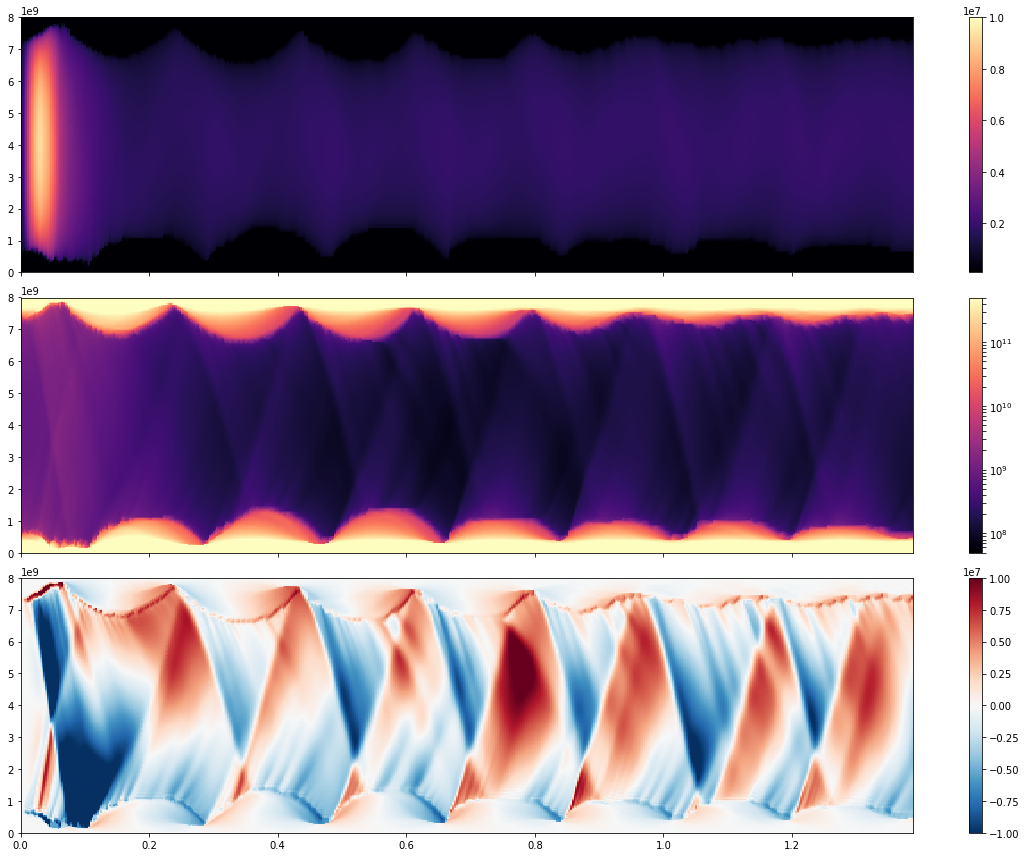

In [85]:
fig,axes = plt.subplots(3,1,figsize=(20,15),sharex=True,sharey=True)
s_grid,t_grid = np.meshgrid(s_interp, s.time.value)
im = axes[0].pcolormesh(t_grid/3600, s_grid, Te_grid,cmap='magma', vmin=1e5,vmax=1e7)
fig.colorbar(im,ax=axes[0])
im = axes[1].pcolormesh(t_grid/3600, s_grid, ne_grid,cmap='magma',
                   norm=matplotlib.colors.LogNorm(vmin=5e7,vmax=5e11))
fig.colorbar(im,ax=axes[1])
im = axes[2].pcolormesh(t_grid/3600, s_grid, v_grid,cmap='RdBu_r',vmin=-1e7,vmax=1e7)
fig.colorbar(im,ax=axes[2])
#axes[0].set_xscale('log')
plt.subplots_adjust(hspace=0.1,wspace=0)

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(12,12),sharex=True)
color_list = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=0,vmax=s.time.shape[0]),
    cmap='plasma',
)
for i,p in enumerate(s):
    axes[0,0].plot(p.coordinate, p.electron_temperature.to(u.MK), color=color_list.to_rgba(i), alpha=0.2)
    #axes[0,0].plot(p.coordinate, p.ion_temperature, color='C1', alpha=0.2)
    axes[0,1].plot(p.coordinate, p.ion_density, color=color_list.to_rgba(i),alpha=0.2)
    axes[1,0].plot(p.coordinate, p.velocity, color=color_list.to_rgba(i), alpha=0.2)
    axes[1,1].plot(p.coordinate, p.electron_pressure, color=color_list.to_rgba(i), alpha=0.2)
    #axes[1,1].plot(p.coordinate, p.ion_pressure, color='C1', alpha=0.2)
axes[0,1].set_yscale('log')
axes[1,1].set_yscale('log')
plt.subplots_adjust(hspace=0., wspace=0.15)

## Test Input Files

In [7]:
print(c.heating_cfg)

AttributeError: No background heating found

In [ ]:
print(c.heating_header)

In [ ]:
print(c.collisions_header)

In [ ]:
print(c.radiation_header)

In [ ]:
print(c.radiation_nonequilibrium_cfg)

In [6]:
print(c.radiation_equilibrium_cfg)

ranges
chianti_v7
asplund
chianti_v7
1
h
1

Configuration file generated by hydrad_tools on 2018-03-26_01.05.17


In [5]:
print(c.hydrad_header)

// ****
// *
// * #defines for configuring the hydrodynamic model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-03-26_00.59.38
// *
// ****

// **** Output ****
#define WRITE_FILE_PHYSICAL




#define OUTPUT_EVERY_N_TIME_STEPS 1000
// **** End of Output ****

// **** Physics ****
#include "../../Heating_Model/source/config.h"
#include "../../Radiation_Model/source/config.h"
#define HEAT_FLUX_LIMITING_COEFFICIENT 1.0
#define TIME_STEP_LIMIT 1e-10

#include "collisions.h"


// **** End of Physics ****

// **** Solver ****
#define SAFETY_RADIATION 1.0
#define SAFETY_CONDUCTION 1.0
#define SAFETY_ADVECTION 1.0
#define SAFETY_VISCOSITY 1.0
#define TIME_STEP_INCREASE_LIMIT 1.05

#define MINIMUM_RADIATION_TEMPERATURE 20000.0
#define ZERO_OVER_TEMPERATURE_INTERVAL 500.0
#define MINIMUM_TEMPERATURE 10000.0
// **** End of Solver ****

// **** Grid ****
#define MAX_REFINEMENT_LEVEL 12
#define ADAPT

#define REFINE_ON_ELECTRON_ENERGY

#define MIN_FRA

In [20]:
c.config['solver']['timestep_increase_limit']

<Quantity 5. %>

In [ ]:
print(c.hydrad_cfg)

In [ ]:
c.date

In [9]:
print(c.intial_conditions_cfg)

Initial_Conditions/profiles/initial.amr

8000000000.0
0.0
500000000.0

20000.0

100000000000.0

4000000000.0
1e+300
-8.0
2.0
0.001
10000.0

Configuration file generated by hydrad_tools on 2018-03-26_00.42.20


In [8]:
print(c.initial_conditions_header)

// ****
// *
// * #defines for configuring the hydrostatic model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-03-26_00.38.59
// *
// ****

// **** Output ****
// **** End of Output ****

// **** Physics ****
#include "../../Radiation_Model/source/config.h"



// **** Solver ****
#define EPSILON 0.01

// **** Grid ****
#define ADAPT
#define MIN_CELLS 150
#define MAX_CELLS 30000
#define MAX_REFINEMENT_LEVEL 12
#define MIN_DS 1.0
#define MAX_VARIATION 1.1


In [ ]:
(5*u.percent).to('percent').value

In [ ]:
git.Repo.clone_from('https://github.com/rice-solar-physics/HYDRAD', '/Users/willbarnes/Desktop/HYDRAD')